In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.stem.porter import PorterStemmer
# nltk.download('stopwords')
from nltk.corpus import stopwords
STOPWORDS = set(stopwords.words('english'))

In [6]:
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from wordcloud import WordCloud
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
import pickle 
import re

In [8]:
data = pd.read_csv("amazon_alexa.tsv", delimiter='\t', quoting=3)
data.head()

,rating,date,variation,verified_reviews,feedback
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1
2,4,31-Jul-18,Walnut Finish,"""Sometimes while playing a game, you can answe...",1
3,5,31-Jul-18,Charcoal Fabric,"""I have had a lot of fun with this thing. My 4...",1
4,5,31-Jul-18,Charcoal Fabric,Music,1


In [9]:
data['feedback'].value_counts()

feedback
1    2893
0     257
Name: count, dtype: int64

In [10]:
data['variation'].value_counts()

variation
Black  Dot                      516
Charcoal Fabric                 430
Configuration: Fire TV Stick    350
Black  Plus                     270
Black  Show                     265
Black                           261
Black  Spot                     241
White  Dot                      184
Heather Gray Fabric             157
White  Spot                     109
White                            91
Sandstone Fabric                 90
White  Show                      85
White  Plus                      78
Oak Finish                       14
Walnut Finish                     9
Name: count, dtype: int64

In [14]:
print(data.columns.values)

['rating' 'date' 'variation' 'verified_reviews' 'feedback']


In [16]:
data.isnull().sum()

rating              0
date                0
variation           0
verified_reviews    1
feedback            0
dtype: int64

In [24]:
data[data['verified_reviews'].isna() == True]

,rating,date,variation,verified_reviews,feedback
473,2,29-Jun-18,White,NaN,0


In [25]:
data.dropna(inplace = True)

In [26]:
len(data)

3149

In [27]:
data.isna().sum()

rating              0
date                0
variation           0
verified_reviews    0
feedback            0
dtype: int64

In [31]:
data.rating.value_counts()

rating
5    2286
4     455
1     161
3     152
2      95
Name: count, dtype: int64

In [30]:
data.head(1)

,rating,date,variation,verified_reviews,feedback
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1


In [32]:
data["length"] = data["verified_reviews"].apply(len)

In [33]:
data.head(2)

,rating,date,variation,verified_reviews,feedback,length
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1,13
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1,9


In [36]:
print(f"10th row", data.iloc[10]['verified_reviews'])
print(f"10th row manual length", len(data.iloc[10]['verified_reviews']))
print(f"10th row length column values: ", data.iloc[10]['length'])

10th row "I sent it to my 85 year old Dad, and he talks to it constantly."
10th row manual length 65
10th row length column values:  65


In [38]:
data.dtypes

rating               int64
date                object
variation           object
verified_reviews    object
feedback             int64
length               int64
dtype: object

Integer values - rating, feedback , length  
String values - verified_reviews, date, variation

In [39]:
len(data)

3149

In [41]:
data.shape

(3149, 6)

##### Analysing rating column

In [43]:
data.head()

,rating,date,variation,verified_reviews,feedback,length
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1,13
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1,9
2,4,31-Jul-18,Walnut Finish,"""Sometimes while playing a game, you can answe...",1,197
3,5,31-Jul-18,Charcoal Fabric,"""I have had a lot of fun with this thing. My 4...",1,174
4,5,31-Jul-18,Charcoal Fabric,Music,1,5


In [45]:
data['rating'].value_counts()

rating
5    2286
4     455
1     161
3     152
2      95
Name: count, dtype: int64

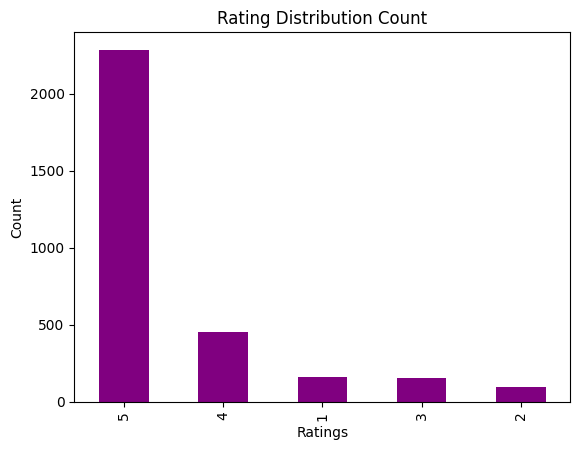

In [48]:
data['rating'].value_counts().plot.bar(color = 'purple')
plt.title("Rating Distribution Count")
plt.xlabel("Ratings")
plt.ylabel("Count")
plt.show()

In [51]:
round(data['rating'].value_counts(normalize=True)*100, 2)

rating
5    72.59
4    14.45
1     5.11
3     4.83
2     3.02
Name: proportion, dtype: float64

<Axes: ylabel='Percentage wise distribution of ratings'>

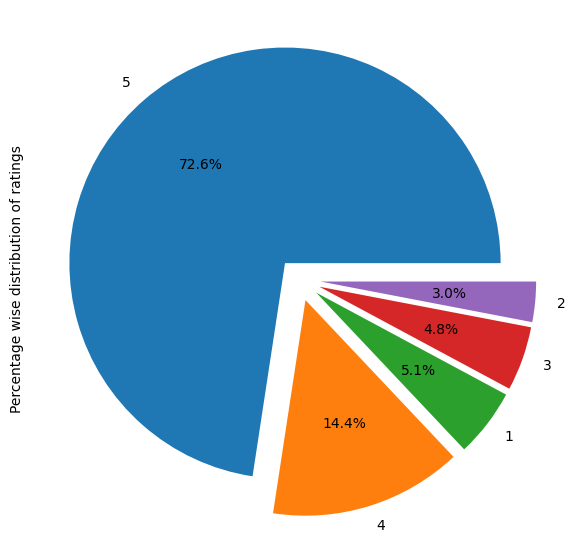

In [66]:
fig = plt.figure(figsize=(7,7))
tags = data['rating'].value_counts(normalize=True) * 100
explode = tuple([0.1])* 5
tags.plot(kind = 'pie', autopct = "%1.1f%%", explode=explode, label = "Percentage wise distribution of ratings")

In [67]:
from io import BytesIO
graph = BytesIO()
fig.savefig(graph, format = 'png')

Analysing 'feedback' column

In [ ]:
data['feedback'].value_counts()

feedback
1    2893
0     256
Name: count, dtype: int64

<Axes: xlabel='feedback'>

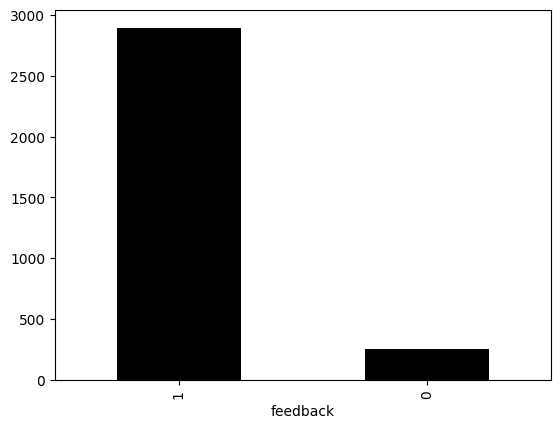

In [71]:
data['feedback'].value_counts().plot(kind = 'bar', color = 'black')

In [72]:
data.head(1)

,rating,date,variation,verified_reviews,feedback,length
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1,13


In [74]:
data.shape

(3149, 6)

In [75]:
# Identifying if 1 represents positive review or a negative one 

data[data['feedback'] == 1].iloc[1]['verified_reviews']

'Loved it!'

In [77]:
data[data['feedback'] == 0].iloc[10]['verified_reviews']

'Item no longer works after just 5 months of use. Will not connect to wifi and unresponsive to reset requests.'

0 - Negative Review   
1 - Positive Review

<Axes: ylabel='proportion'>

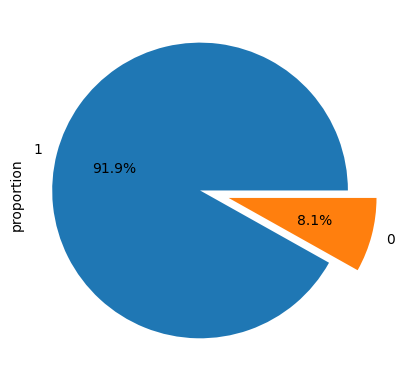

In [80]:
tags = data['feedback'].value_counts(normalize=True)
explode = tuple([0.1]) * 2
tags.plot(kind = "pie", autopct = "%1.1f%%", explode = explode)

In [81]:
data[data['feedback'] == 0]['rating'].value_counts()

rating
1    161
2     95
Name: count, dtype: int64

In [82]:
data[data['feedback'] == 1]['rating'].value_counts()

rating
5    2286
4     455
3     152
Name: count, dtype: int64

If rating of a review is 1 or 2 then the feedback is 0 (negative) and if the rating is 3, 4 or 5 then the feedback is 1 (positive).

#### Analyzing variation column

In [83]:
data.variation.value_counts()

variation
Black  Dot                      516
Charcoal Fabric                 430
Configuration: Fire TV Stick    350
Black  Plus                     270
Black  Show                     265
Black                           261
Black  Spot                     241
White  Dot                      184
Heather Gray Fabric             157
White  Spot                     109
Sandstone Fabric                 90
White                            90
White  Show                      85
White  Plus                      78
Oak Finish                       14
Walnut Finish                     9
Name: count, dtype: int64

<Axes: xlabel='variation'>

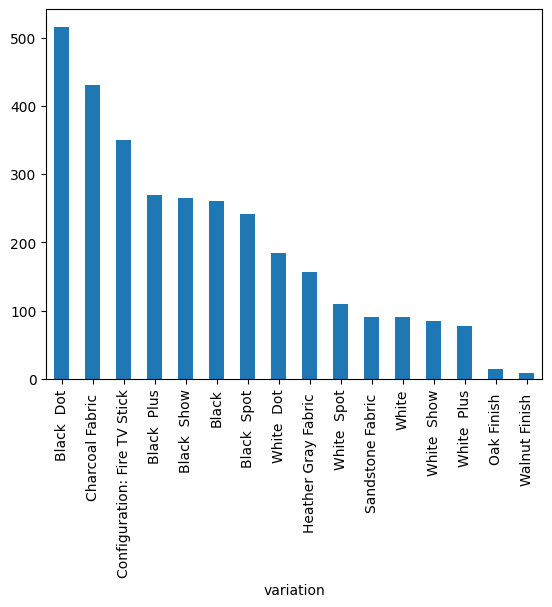

In [84]:
data.variation.value_counts().plot(kind = 'bar')

In [85]:
data.head(1)

,rating,date,variation,verified_reviews,feedback,length
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1,13


In [86]:
data.groupby('variation')['rating'].mean()

variation
Black                           4.233716
Black  Dot                      4.453488
Black  Plus                     4.370370
Black  Show                     4.490566
Black  Spot                     4.311203
Charcoal Fabric                 4.730233
Configuration: Fire TV Stick    4.591429
Heather Gray Fabric             4.694268
Oak Finish                      4.857143
Sandstone Fabric                4.355556
Walnut Finish                   4.888889
White                           4.166667
White  Dot                      4.423913
White  Plus                     4.358974
White  Show                     4.282353
White  Spot                     4.311927
Name: rating, dtype: float64

<Axes: xlabel='variation'>

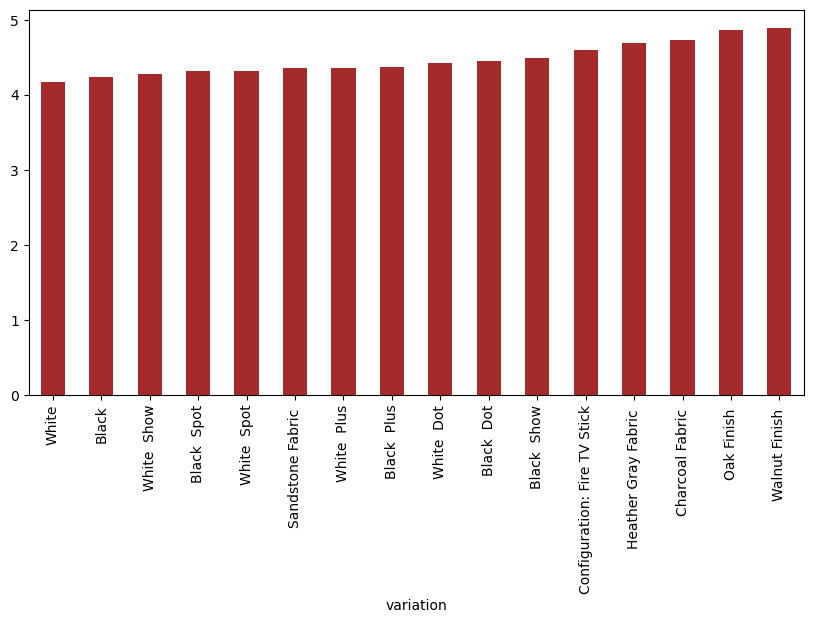

In [91]:
data.groupby('variation')['rating'].mean().sort_values().plot(kind = 'bar', color = 'brown', figsize=(10,5))

In [92]:
data.head(1)

,rating,date,variation,verified_reviews,feedback,length
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1,13


#### Analysing verified_reviews

In [93]:
data['length'].describe()

count    3149.000000
mean      132.714513
std       182.541531
min         1.000000
25%        30.000000
50%        74.000000
75%       166.000000
max      2853.000000
Name: length, dtype: float64

<Axes: xlabel='length', ylabel='Count'>

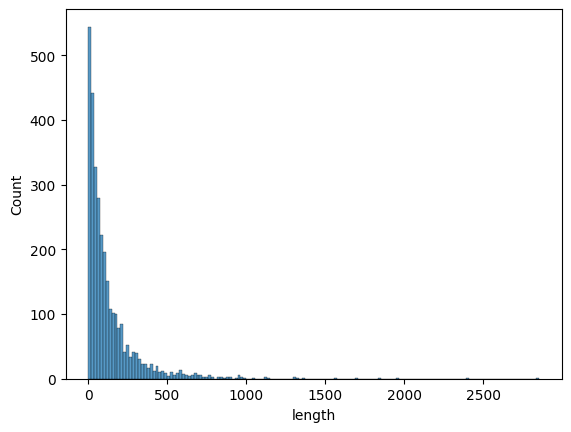

In [95]:
sns.histplot(data['length'])

<Axes: ylabel='Frequency'>

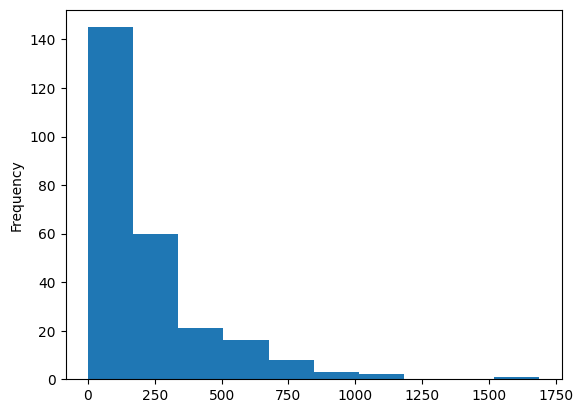

In [98]:
data[data['feedback'] == 0]['length'].plot(kind = 'hist')

<Axes: ylabel='Frequency'>

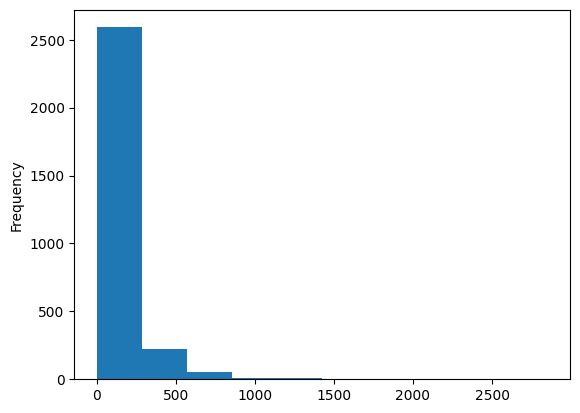

In [99]:
data[data['feedback'] == 1]['length'].plot(kind = 'hist')

In [100]:
data['length'].value_counts()

length
1      81
11     48
13     44
8      41
22     36
       ..
400     1
198     1
397     1
582     1
401     1
Name: count, Length: 495, dtype: int64

<Axes: ylabel='Frequency'>

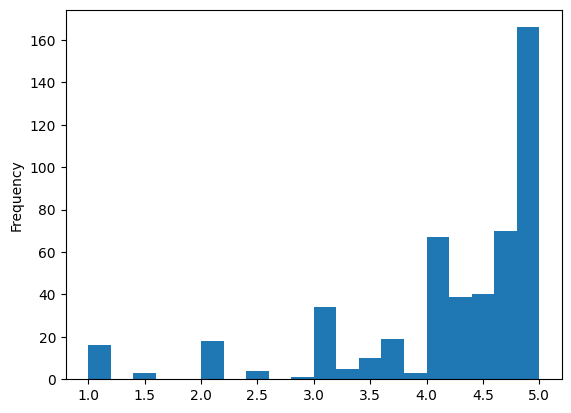

In [103]:
data.groupby('length')['rating'].mean().plot(kind = 'hist', bins = 20)

In [104]:
data.head(1)

,rating,date,variation,verified_reviews,feedback,length
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1,13


In [105]:
cv = CountVectorizer(stop_words='english')
words = cv.fit_transform(data.verified_reviews)

In [113]:
reviews = " ".join([review for review in data['verified_reviews']])

In [114]:
len(reviews)

421066

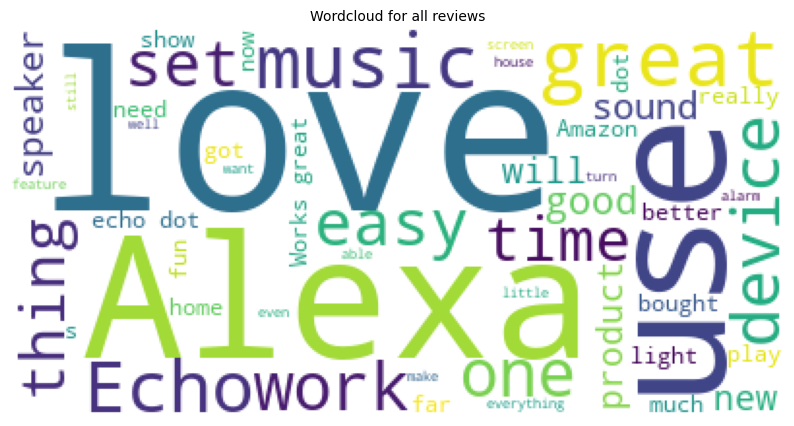

In [115]:
wc = WordCloud(background_color='white', max_words=50)
plt.figure(figsize=(10,10))
plt.imshow(wc.generate(reviews))
plt.title('Wordcloud for all reviews', fontsize=10)
plt.axis('off')
plt.show()

In [ ]:
negative_reviews = " ".join([review for review in data[data['feedback'] == 0]['verified_reviews']])


In [ ]:
negative_reviews = negative_reviews.lower().split()

In [127]:
positive_reviews = " ".join([review for review in data[data['feedback'] == 1]['verified_reviews']])
positive_reviews = positive_reviews.lower().split()

In [128]:
unique_negative = [x for x in negative_reviews if x not in positive_reviews]
unique_negative = " ".join(unique_negative)

In [133]:
unique_positive = [x for x in positive_reviews if x not in negative_reviews]
unique_positive = " ".join(unique_positive)

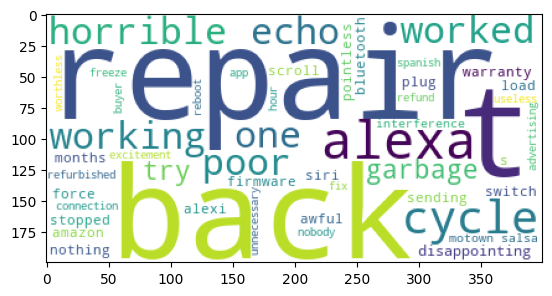

In [134]:
plt.imshow(wc.generate(unique_negative))

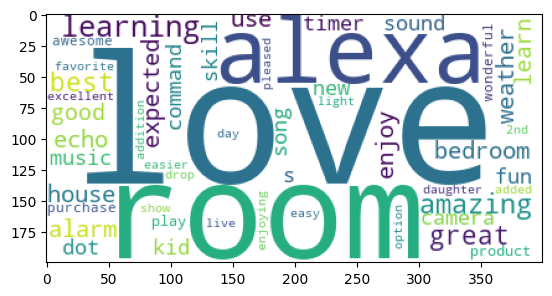

In [135]:
plt.imshow(wc.generate(unique_positive))

Preprocessing and modelling 

[^a-zA-Z] = anything that is NOT a letter

In [140]:
corpus = []
stemmer = PorterStemmer()
for i in range(data.shape[0]):
    review = re.sub('^[a-zA-Z]', ' ', data.iloc[i]['verified_reviews'])
    review = review.lower().split()
    review = [stemmer.stem(word) for word in review if word not in STOPWORDS]
    review = ' '.join(review)
    corpus.append(review)


In [ ]:
# review = re.sub('^[a-zA-Z]', ' ', data.iloc[0]['verified_reviews'])
# review 

' ove my Echo!'

In [146]:
corpus[17]

'e use alexa coupl day lot fun new toy. like new household member! tri learn differ featu benefit come it.'

In [161]:
cv = CountVectorizer(max_features=2500)
X = cv.fit_transform(corpus).toarray()
y = data['feedback'].values

In [162]:
print(X.shape)

(3149, 2500)


In [164]:
print(y.shape)

(3149,)


In [165]:
pickle.dump(cv, open('countVectorizer.pkl', 'wb'))

In [166]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=15)

In [167]:
X_train

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [168]:
y_train

array([1, 1, 0, ..., 1, 1, 1], dtype=int64)

In [169]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [171]:
#Saving the scaler model
pickle.dump(scaler, open('scaler.pkl', 'wb'))

RandomForest 

In [172]:
model_rf = RandomForestClassifier()
model_rf.fit(X_train_scaled, y_train)

RandomForestClassifier()

In [173]:
print(f"Train accuracy: {model_rf.score(X_train_scaled, y_train)}")
print(f"Test accuracy: {model_rf.score(X_test_scaled, y_test)}")

Train accuracy: 0.9956331877729258
Test accuracy: 0.946031746031746


In [174]:
y_preds = model_rf.predict(X_test_scaled)

In [175]:
cm = confusion_matrix(y_test, y_preds)

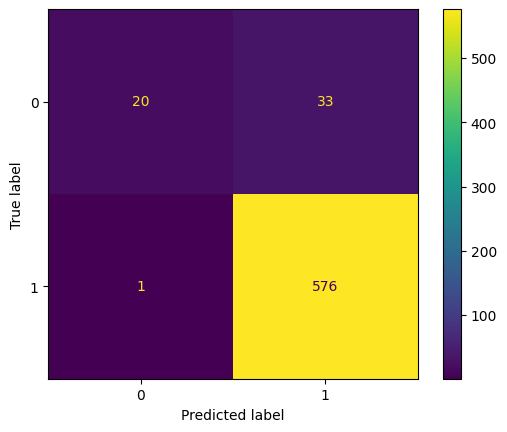

In [176]:
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model_rf.classes_)
cm_display.plot()
plt.show()

K-fold Cross Validation

In [177]:
accuracies = cross_val_score(estimator=model_rf, X = X_train_scaled, y = y_train, cv=10)
print(f"Accuracy: {accuracies.mean()}")
print(f"Standard Variance: {accuracies.std()}")

Accuracy: 0.9380699424524126
Standard Variance: 0.00855291330462227


Grid Search to get Optimal Hyperparameters 

In [178]:
params = {
    'bootstrap' : [True],
    'max_depth' : [80, 100],
    'min_samples_split' : [8, 12],
    'n_estimators': [100, 300]
}

In [179]:
cv_obj = StratifiedKFold(n_splits=2)
grid_search = GridSearchCV(estimator=model_rf, param_grid=params, cv = cv_obj, verbose = 0, return_train_score=True)
grid_search.fit(X_train_scaled, y_train.ravel())

GridSearchCV(cv=StratifiedKFold(n_splits=2, random_state=None, shuffle=False),
             estimator=RandomForestClassifier(),
             param_grid={'bootstrap': [True], 'max_depth': [80, 100],
                         'min_samples_split': [8, 12],
                         'n_estimators': [100, 300]},
             return_train_score=True)

In [180]:
# best_params
grid_search.best_params_

{'bootstrap': True,
 'max_depth': 100,
 'min_samples_split': 8,
 'n_estimators': 100}

In [181]:
print(f"CV mean accuracy on train set {grid_search.cv_results_['mean_train_score'].mean() * 100}")
print(f"CV mean accuracy on test set {grid_search.cv_results_['mean_test_score'].mean() * 100}")
print("Accuracy score for test set :", accuracy_score(y_test, y_preds))

CV mean accuracy on train set 96.70497024597502
CV mean accuracy on test set 92.25389103218728
Accuracy score for test set : 0.946031746031746
